In [2]:

import numpy as np
import matplotlib.pyplot as plt
import functools

# Overview

In [3]:
# This notebook aims to help the reader understand the NSGA-2 algorithm decribed in the paper: 
# A Fast and Elitist Multiobjective Genetic Algorithm: NSGA-II 
# Kalyanmoy Deb, Associate Member, IEEE, Amrit Pratap, Sameer Agarwal, and T. Meyarivan

# This tutorial assumes familiarity with genetic algorithms, but no prior knowladge on multi objective optimization
# NOTE, in all the examples optimize means maximize, this is a convention.

# Content:
#     - Concepts: Domination, Multi objective optimization, Pareto front
#     - A real world example: Starcraft build orders
#     - A simple example
#     - Brute force solution
#     - Non dominated sorting: naive approach (worst case complexity O(M N^3))
#     - Non dominated sorting: fast approach (worst case complexity O(M N^2) )
#     - Diversity Preservation
#     - Putting it all togeather
#     - Solving the toy problem
#     - Solving a more complex problem
#     - Making it faster

### Concepts

In [4]:
# With Multiobjective optimization, we simultaneously optimize for multiple objectives.
# The goal of the multiobjective optimization is to find a set of solutions which is not dominated by any other solution.

# But what is domination?
# A solution dominates another solution if in all of the objectives it is better or equal, and in at least one it is better.

def dominates(fitnesses_1,fitnesses_2):
    # fitnesses_1 is a array of objectives of solution 1 [objective1, objective2 ...]
    larger_or_equal = fitnesses_1 >= fitnesses_2
    larger = fitnesses_1 > fitnesses_2
    if np.all(larger_or_equal) and np.any(larger):
        return True
    return False

# A set of solutions which do not dominate each other is called a Pareto front.
# When there is no solution which dominates any of members of the front, it is called an optimal Pareto front.
# The goeal of multiobjective optimization is to find the optimal Pareto front.

### A real world example: Starcraft build orders

In [5]:
# People were using genetic algorithms to find optimal build orders for stracraft.
# How would we use multiobjective optimization for this? 
# One objective can be the size of our economy after 5 minutes
# Another objective can be the size of our army after 5 minutes
# The goal is to find a set of build orders (with various tradoff between the objectives), which are not dominated by any other build orders.


### A simple example

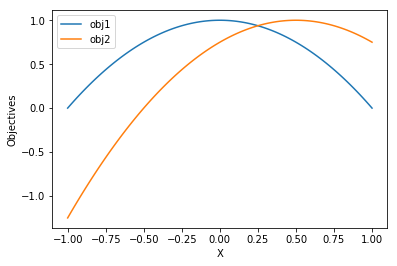

Text(0, 0.5, 'obj1')

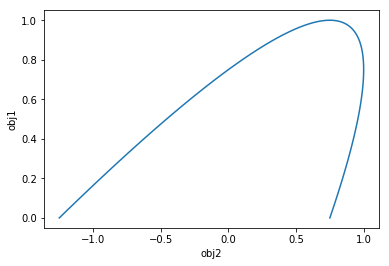

In [6]:
# optimize the scalar x
# for objectives obj1 and obj2:
def obj1(x):
    return 1 - x * x
def obj2(x):
    return 1 - (x-0.5) * (x-0.5)

# Let us plot the objetives for all possible x
x = np.linspace(-1,1,100)
plt.plot(x,obj1(x))
plt.plot(x,obj2(x))
plt.xlabel("X")
plt.ylabel("Objectives")
plt.legend(["obj1","obj2"])
plt.show()
# and plot the objectives against each other
plt.plot(obj2(x),obj1(x))
plt.xlabel("obj2")
plt.ylabel("obj1")


### A brute force solution

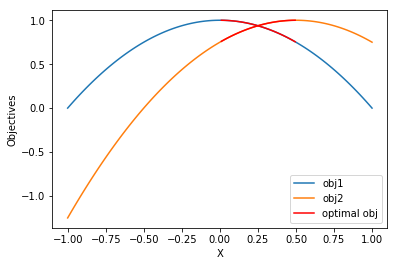

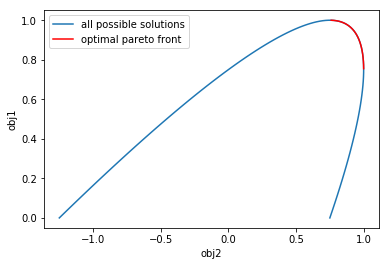

In [7]:
# Let solve this toy example by comparing evey possible solution to each other, and get the set which no other solution dominates
all_possible_solution = np.linspace(-1,1,100)
all_fitnesses = np.stack( [obj1(all_possible_solution),obj2(all_possible_solution)],axis=1)
nondominated_indicies = []
for i in range(len(all_possible_solution)):
    dominated = False
    for j in range(len(all_possible_solution)):
        if dominates(all_fitnesses[j],all_fitnesses[i]):
            dominated = True
            break
    if dominated is False:
        nondominated_indicies.append(i)

nondominated_solutions = all_possible_solution[nondominated_indicies]

# Plot the optimal values togeather with all values
plt.plot(x,obj1(x))
plt.plot(x,obj2(x))
plt.plot(x[nondominated_indicies],obj1(x)[nondominated_indicies],color="red")
plt.plot(x[nondominated_indicies],obj2(x)[nondominated_indicies],color="red")
plt.xlabel("X")
plt.ylabel("Objectives")
plt.legend(["obj1","obj2","optimal obj"])
plt.show()

plt.plot(obj2(x),obj1(x))
plt.plot(obj2(x)[nondominated_indicies],obj1(x)[nondominated_indicies],color="red")
plt.xlabel("obj2")
plt.ylabel("obj1")
plt.legend(["all possible solutions","optimal pareto front"])

### Non dominated sorting: naive approach (worst case complexity O(M N^3))

Front:  [1, 7, 59]
Front:  [15, 28, 63, 70, 72, 85]
Front:  [3, 5, 9, 14, 24, 36, 39, 58, 95]
Front:  [23, 26, 48, 68, 77, 86, 88, 91]
Front:  [6, 18, 35, 46, 47, 74, 84, 90]
Front:  [2, 31, 33, 44, 45, 51, 66, 73, 78, 87]
Front:  [20, 30, 32, 76, 79, 94]
Front:  [0, 8, 12, 34, 37, 42, 49, 82, 96]
Front:  [22, 27, 43, 53, 61, 71, 80]
Front:  [16, 17, 21, 38, 41, 69, 93, 99]
Front:  [11, 57, 60, 62, 64, 92]
Front:  [10, 13, 29, 50, 55]
Front:  [19, 25, 54]
Front:  [52, 65, 75, 89, 98]
Front:  [56, 81]
Front:  [4, 67, 83, 97]
Front:  [40]
Done


Text(0, 0.5, 'obj2')

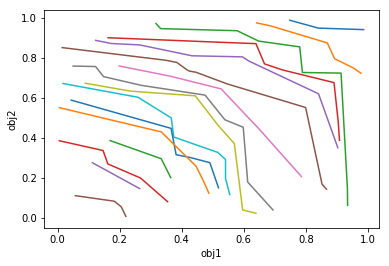

In [8]:
# To use multiobjectve optimization with genetic algorithms, we need to rank individuals
# To do this, we calculate which front they belong to.
# Individuals which are not dominated belong to the fisrt front.
# Then we temporarily remove the first front, and calculate the set of individuals that are not dominated in the reduced set. 
# This becomes the second front and so on.

# For this example, we start with a list of fitness values for each objective. (randomly generated)
# Normally we would get this values by evaluating solutions on a task.
pop_size = 100
all_fitnesses = np.random.rand(pop_size,2)

fronts = []

remaining_indicies = list(range(pop_size))
while True:
    
    non_dominated_indicies = []
    
    for i in remaining_indicies:
        dominated = False
        for j in remaining_indicies:
            if dominates(all_fitnesses[j],all_fitnesses[i]):
                dominated = True
                break
                
        if dominated is False:
            non_dominated_indicies.append(i)
            
    print("Front: ",non_dominated_indicies)
    
    # remove current front from remaining indicies
    fronts.append(non_dominated_indicies)
    remaining_indicies = [x for x in remaining_indicies if x not in non_dominated_indicies] 
    
    if len(remaining_indicies) == 0:
        print("Done")
        break
        
        
# Let us plot the fronts
for i in range(len(fronts)):
    # before plotting, sort by obj 1
    sorted_front = sorted(fronts[i],key=lambda x : all_fitnesses[x,0])
    plt.plot(all_fitnesses[sorted_front,0],all_fitnesses[sorted_front,1])#,".")
plt.xlabel("obj1")
plt.ylabel("obj2")




### Non dominated sorting: fast approach (worst case complexity O(M N^2) )

Text(0, 0.5, 'obj2')

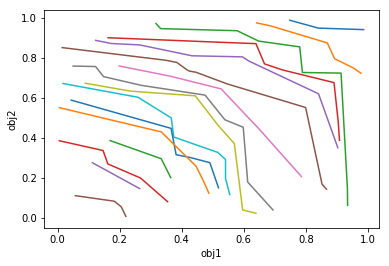

In [9]:
# The fast implementation of non dominated sort, as described in the original NSGA-II paper 
# We pre calculate the domination set for each individual (the set of other individuals this individual dominates)
# And we precalculate the domination counts (how many other individuals dominates this individual)
# Once we have these two things, calculating the fronts are simple:
#  - Current front is the individuals whose domination count is 0
#  - Then visit everyone in the current front's domination set, and reduce their domination count.
#  - Remove current front and Repeat

def calculate_pareto_fronts(fitnesses):
    
    # Calculate dominated set for each individual
    domination_sets = []
    domination_counts = []
    for fitnesses_1 in fitnesses:
        current_dimination_set = set()
        domination_counts.append(0)
        for i,fitnesses_2 in enumerate(fitnesses):
            if dominates(fitnesses_1,fitnesses_2):
                current_dimination_set.add(i)
            elif dominates(fitnesses_2,fitnesses_1):
                domination_counts[-1] += 1

        domination_sets.append(current_dimination_set)

    domination_counts = np.array(domination_counts)
    fronts = []
    while True:
        current_front = np.where(domination_counts==0)[0]
        if len(current_front) == 0:
            #print("Done")
            break
        #print("Front: ",current_front)
        fronts.append(current_front)

        for individual in current_front:
            domination_counts[individual] = -1 # this individual is already accounted for, make it -1 so  ==0 will not find it anymore
            dominated_by_current_set = domination_sets[individual]
            for dominated_by_current in dominated_by_current_set:
                domination_counts[dominated_by_current] -= 1
            
    return fronts

# We use all_fitnesses defined in the previous example 
fronts = calculate_pareto_fronts(all_fitnesses)

# Let us plot the fronts
legends = []
for i in range(len(fronts)):
    # before plotting, sort by obj 1
    sorted_front = sorted(fronts[i],key=lambda x : all_fitnesses[x,0])
    plt.plot(all_fitnesses[sorted_front,0],all_fitnesses[sorted_front,1])#,".")
    
plt.xlabel("obj1")
plt.ylabel("obj2")

### Diversity Preservation (crowding metric)

Text(0.5, 1.0, 'Point size indicates crowdedness (smaller more crowded)')

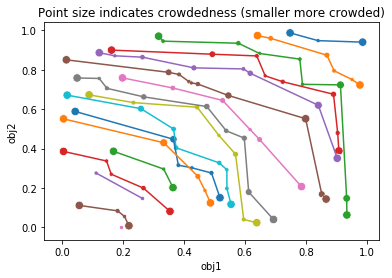

In [10]:
# An important aspect of multiobjective optimization is that we explore the different possible tradoffs.
# To do this effectively we need to encourage a diversity in the population.
# NSGA-II uses a crowding metric to do this.
# The crowding metric is based on how close the neerest neighbors in the same front are for each objective. 


def calculate_crowding_metrics(fitnesses,fronts):
    
    num_objectives = fitnesses.shape[1]
    num_individuals = fitnesses.shape[0]
    
    # Normalise each objectives, so they are in the range [0,1]
    # This is necessary, so each objective's contribution have the same magnitude to the crowding metric.
    normalized_fitnesses = np.zeros_like(fitnesses)
    for objective_i in range(num_objectives):
        min_val = np.min(fitnesses[:,objective_i])
        max_val = np.max(fitnesses[:,objective_i])
        val_range = max_val - min_val
        normalized_fitnesses[:,objective_i] = (fitnesses[:,objective_i] - min_val) / val_range
    
    fitnesses = normalized_fitnesses
    crowding_metrics = np.zeros(num_individuals)

    for front in fronts:
        for objective_i in range(num_objectives):
            
            sorted_front = sorted(front,key = lambda x : fitnesses[x,objective_i])
            
            crowding_metrics[sorted_front[0]] = np.inf
            crowding_metrics[sorted_front[-1]] = np.inf
            if len(sorted_front) > 2:
                for i in range(1,len(sorted_front)-1):
                    crowding_metrics[sorted_front[i]] += fitnesses[sorted_front[i+1],objective_i] - fitnesses[sorted_front[i-1],objective_i]

    return  crowding_metrics

# Let us plot the crowding metric for the previous example
crowding_metrics = calculate_crowding_metrics(all_fitnesses,fronts)
crowding_metrics[crowding_metrics == np.inf] = np.max(crowding_metrics[crowding_metrics != np.inf])  # replace inf with max

import seaborn
for i in range(len(fronts)):
    # before plotting, sort by obj 1
    sorted_front = sorted(fronts[i],key=lambda x : all_fitnesses[x,0])
    plt.plot(all_fitnesses[sorted_front,0],all_fitnesses[sorted_front,1])#,".")
    seaborn.scatterplot(x=all_fitnesses[sorted_front,0],y=all_fitnesses[sorted_front,1],size=crowding_metrics[sorted_front],legend=False)
plt.xlabel("obj1")
plt.ylabel("obj2")
plt.title("Point size indicates crowdedness (smaller more crowded)")


### Sorting with domination and crowding

In [11]:
# For sorting the population we need both the nondomination rank and the crowding metric
# We always consider the nondomination rank first, but in a tie we use the crowding metric

# helper function
def fronts_to_nondomination_rank(fronts):
    nondomination_rank_dict = {}
    for i,front in enumerate(fronts):
        for x in front:   
            nondomination_rank_dict[x] = i
    return nondomination_rank_dict
        

def nondominated_sort(nondomination_rank_dict,crowding):
    
    num_individuals = len(crowding)
    indicies = list(range(num_individuals))

    def nondominated_compare(a,b):
        # returns 1 if a dominates b, or if they equal, but a is less crowded
        # return -1 if b dominates a, or if they equal, but b is less crowded
        # returns 0 if they are equal in every sense
        
        
        if nondomination_rank_dict[a] > nondomination_rank_dict[b]:  # domination rank, smaller better
            return -1
        elif nondomination_rank_dict[a] < nondomination_rank_dict[b]:
            return 1
        else:
            if crowding[a] < crowding[b]:   # crowding metrics, larger better
                return -1
            elif crowding[a] > crowding[b]:
                return 1
            else:
                return 0

    non_domiated_sorted_indicies = sorted(indicies,key = functools.cmp_to_key(nondominated_compare),reverse=True) # decreasing order, the best is the first
    return non_domiated_sorted_indicies

# Test
nondomination_rank_dict = fronts_to_nondomination_rank(fronts)
sorted_indicies = nondominated_sort(nondomination_rank_dict,crowding_metrics)

### Putting it all togeather

In [12]:
# Some generic GA functions
def touranment_selection(num_parents,num_offspring):
    offspring_parents = []
    for _ in range(num_offspring):
        contestants = np.random.randint(0,num_parents,2) # generate 2 random numbers, take the smaller (parent list is already sorted, smaller index, better)
        winner = np.min(contestants)
        offspring_parents.append(winner)
    
    return offspring_parents

# simple mutation
def get_mutated_copy(parent,min_val,max_val,mutation_power_ratio):
    mutation_power = (max_val - min_val) * mutation_power_ratio
    offspring = parent.copy()
    offspring += np.random.normal(0,mutation_power,size = offspring.shape)
    offspring = np.clip(offspring,min_val,max_val)
    return offspring



def NSGA2_create_next_generation(pop,fitnesses,config):
    
    # algorithm and task parameters
    half_pop_size = config["half_pop_size"]
    problem_dim = config["problem_dim"]
    gene_min_val = config["gene_min_val"]
    gene_max_val = config["gene_max_val"]
    mutation_power_ratio = config["mutation_power_ratio"]

    # calculate the pareto fronts and crowding metrics
    fronts = calculate_pareto_fronts(fitnesses)
    nondomination_rank_dict = fronts_to_nondomination_rank(fronts)
    
    crowding = calculate_crowding_metrics(fitnesses,fronts)
    
    # Sort the population
    non_domiated_sorted_indicies = nondominated_sort(nondomination_rank_dict,crowding)
    
    # The better half of the population survives to the next generation and have a chance to reproduce
    # The rest of the population is discarded
    surviving_individuals = pop[non_domiated_sorted_indicies[:half_pop_size]]
    #print(len(surviving_individuals))
    reproducing_individual_indicies = touranment_selection(num_parents=half_pop_size,num_offspring=half_pop_size)
    offsprings = np.array([get_mutated_copy(surviving_individuals[i],gene_min_val,gene_max_val,mutation_power_ratio) for i in reproducing_individual_indicies])
    
    new_pop = np.concatenate([surviving_individuals,offsprings])  # concatenate the 2 lists
    return new_pop
        

### Solving the toy problem

Text(0, 0.5, 'obj2')

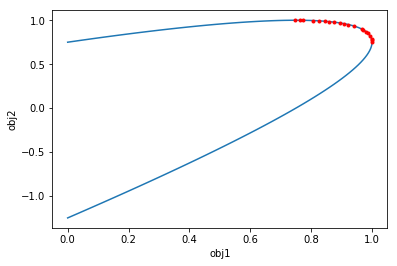

In [13]:
def simple_1d_fitness_func(x):
    objective_1 = 1-(x * x)
    objective_2 = 1-((x-0.5) * (x-0.5))
    return np.stack([objective_1,objective_2],axis=1)

config = {
    "half_pop_size" : 20,
    "problem_dim" : 1,
    "gene_min_val" : -1,
    "gene_max_val" : 1,
    "mutation_power_ratio" : 0.05,
}

pop = np.random.uniform(config["gene_min_val"],config["gene_max_val"],2*config["half_pop_size"])

mean_fitnesses = []
for generation in range(30):
    
    # evaluate pop
    fitnesses = simple_1d_fitness_func(pop)
    mean_fitnesses.append(np.mean(fitnesses,axis=0))
    
    # transition to next generation
    pop = NSGA2_create_next_generation(pop,fitnesses,config)
    
# Check if we found the same solutions as the brute force method
x = np.linspace(-1,1,100)
all_solutions_fitnesses = simple_1d_fitness_func(x)
plt.plot(all_solutions_fitnesses[:,0],all_solutions_fitnesses[:,1])
plt.plot(fitnesses[:config["half_pop_size"],0],fitnesses[:config["half_pop_size"],1],".",color="red")
plt.xlabel("obj1")
plt.ylabel("obj2")


### Solving a more complex problem

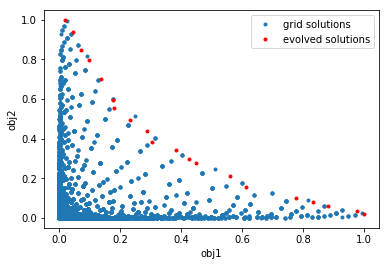

In [14]:
# This is one of the problems from the original paper: FON

def FON_fitness_func(x):
    val = 1 / np.sqrt(3)
    objective_1 = np.exp( - ( (x[:,0]-val)*(x[:,0]-val) + (x[:,1]-val)*(x[:,1]-val) + (x[:,2]-val)*(x[:,2]-val)))
    objective_2 = np.exp( - ( (x[:,0]+val)*(x[:,0]+val) + (x[:,1]+val)*(x[:,1]+val) + (x[:,2]+val)*(x[:,2]+val)))
    return np.stack([objective_1,objective_2],axis=1)

config = {
    "half_pop_size" : 20,
    "problem_dim" : 3,
    "gene_min_val" : -4,
    "gene_max_val" : 4,
    "mutation_power_ratio" : 0.05,
}


pop = np.random.uniform(config["gene_min_val"],config["gene_max_val"],(2*config["half_pop_size"],3))

mean_fitnesses = []
for generation in range(50):
    
    # evaluate pop
    fitnesses = FON_fitness_func(pop)
    mean_fitnesses.append(np.mean(fitnesses,axis=0))
    
    # transition to next generation
    pop = NSGA2_create_next_generation(pop,fitnesses,config)


# To compare the found solutions with other values, we check all solutions in a grid
grid_3d = []
for x in np.linspace(-2,2,20):
    for y in np.linspace(-2,2,20):
        for z in np.linspace(-2,2,20):
            grid_3d.append([x,y,z])
grid_3d = np.array(grid_3d)
all_fitnesses = FON_fitness_func(grid_3d)

plt.plot(all_fitnesses[:,0],all_fitnesses[:,1],".")
plt.plot(fitnesses[:config["half_pop_size"],0],fitnesses[:config["half_pop_size"],1],".",color="red")
plt.xlabel("obj1")
plt.ylabel("obj2")
plt.legend(["grid solutions","evolved solutions"])



### Making it production ready

In [31]:
# If the population size is large, the computation can be quite slow.
# The slowest part is calulating the fronts, which inclused a nested for loops to check who dominates who

pop_size = 2000
all_fitnesses = np.random.rand(pop_size,2)

In [32]:
%%time
fronts = calculate_pareto_fronts(all_fitnesses)

CPU times: user 39.4 s, sys: 50.8 ms, total: 39.4 s
Wall time: 39.5 s


In [26]:
# To speed up this nested for loop, we can vectorize it with numpy.
# This means instead of calulating values one by one in a python loop, we calculate them all at once with numpy. 
# There still going to be a loop inside numpy, but that loop is written in C, and will run much faster.

def calculate_domination_matrix(fitnesses):    
    
    pop_size = fitnesses.shape[0]
    num_objectives = fitnesses.shape[1]
    
    fitness_grid_x = np.zeros([pop_size,pop_size,num_objectives])
    fitness_grid_y = np.zeros([pop_size,pop_size,num_objectives])
    
    for i in range(pop_size):
        fitness_grid_x[i,:,:] = fitnesses[i]
        fitness_grid_y[:,i,:] = fitnesses[i]
    
    larger_or_equal = fitness_grid_x >= fitness_grid_y
    larger = fitness_grid_x > fitness_grid_y
    
    return np.logical_and(np.all(larger_or_equal,axis=2),np.any(larger,axis=2))


def fast_calculate_pareto_fronts(fitnesses):
    
    # Calculate dominated set for each individual
    domination_sets = []
    domination_counts = []
    
    domination_matrix = calculate_domination_matrix(fitnesses)
    pop_size = fitnesses.shape[0]
    
    for i in range(pop_size):
        current_dimination_set = set()
        domination_counts.append(0)
        for j in range(pop_size):
            if domination_matrix[i,j]:
                current_dimination_set.add(j)
            elif domination_matrix[j,i]:
                domination_counts[-1] += 1
                
        domination_sets.append(current_dimination_set)

    domination_counts = np.array(domination_counts)
    fronts = []
    while True:
        current_front = np.where(domination_counts==0)[0]
        if len(current_front) == 0:
            #print("Done")
            break
        #print("Front: ",current_front)
        fronts.append(current_front)

        for individual in current_front:
            domination_counts[individual] = -1 # this individual is already accounted for, make it -1 so  ==0 will not find it anymore
            dominated_by_current_set = domination_sets[individual]
            for dominated_by_current in dominated_by_current_set:
                domination_counts[dominated_by_current] -= 1
            
    return fronts



In [33]:
%%time
fronts = fast_calculate_pareto_fronts(all_fitnesses)

CPU times: user 1.6 s, sys: 60.9 ms, total: 1.66 s
Wall time: 1.66 s


In [ ]:
# The new version is around 24 times faster on my machine